In [2]:
from keras.layers import *
from tensorflow.keras.models import Sequential # Importing the Sequential

model=Sequential()
input_shape=(100,100,3)
model = Sequential()

model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (5, 5),padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())


model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation = 'softmax'))

In [3]:
model.load_weights('/content/drive/MyDrive/Personal/CNN-Best.h5')

In [8]:
import cv2
orig = cv2.imread("/content/CO1-5-6.jpg")
orig = cv2.cvtColor(orig,cv2.COLOR_BGR2RGB)
resized = cv2.resize(orig, (100, 100))
img_data=resized/255

In [9]:
img_data = np.resize(img_data,(1,100,100,3))

In [10]:
import numpy as np
preds = model.predict(img_data)
i = np.argmax(preds[0])
i

1/1 [==============================] - 0s 313ms/step


0

In [17]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
  grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
  with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    if pred_index is None:
      pred_index = tf.argmax(preds[0])
    class_channel = preds[:, pred_index]
  grads = tape.gradient(class_channel, last_conv_layer_output)
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  return heatmap.numpy()

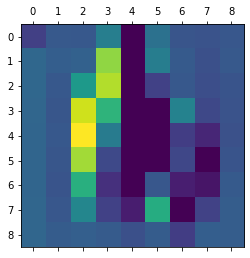

In [19]:
import matplotlib.pyplot as plt
# Remove last layer's softmax
model.layers[-1].activation = None

last_conv_layer_name = "conv2d_3"

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_data, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

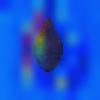

In [26]:
from tensorflow import keras
import matplotlib.cm as cm
from IPython.display import Image, display

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
  img = keras.preprocessing.image.load_img(img_path,target_size=(100,100))
  img = keras.preprocessing.image.img_to_array(img)
  heatmap = np.uint8(255 * heatmap)
  jet = cm.get_cmap("jet")
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
  superimposed_img = jet_heatmap * alpha + img
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
  superimposed_img.save(cam_path)
  display(Image(cam_path))


save_and_display_gradcam('/content/CO1-5-6.jpg', heatmap)

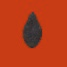

In [25]:
from google.colab.patches import cv_imshow
cv_imshow(orig)